In [1]:
# import lsst.summit.extras

In [2]:
# lsst.summit.__file__

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from lsst.summit.extras.plotting.psfPlotting import makeAzElPlot, makeTableFromSourceCatalogs, makeFocalPlanePlot, makeEquatorialPlot
from lsst.obs.lsst import LsstComCam, LsstCam
import matplotlib.pyplot as plt

In [5]:
from lsst.daf.butler import Butler
import numpy as np

## set up

In [6]:
import sys
# sys.path.append("../../notebooks/")
sys.path.append("/sdf/data/rubin/shared/image_quality/imsim/notebooks/")                #file with convertion between seqnum and collection
from collection_dictionary_shared import collection_dictionary

In [7]:
folder = '/sdf/data/rubin/shared/image_quality/imsim/'
#Define the butler data configuration and collection (una tantum )
config = folder+'repo'
seqnum_base = 5023071800000
collection_dict = collection_dictionary()

# sequence number

In [8]:
seqnum = 182
visitid_complete = seqnum+seqnum_base
collections = collection_dict[visitid_complete]
collections

'pipetask_output/20250214T133845Z'

In [9]:
collection_dict[visitid_complete]

'pipetask_output/20250214T133845Z'

In [10]:
butler = Butler(config, collections=collections)

In [11]:
# butler.collections.query_info(collections[0], include_summary=True)

In [12]:
registry = butler.registry

In [13]:
# for dt in sorted(registry.queryDatasetTypes()):
#     print(dt)

In [14]:
postisr = list(registry.queryDatasets('icSrc', collections=collections, detector=90))
postisr
#exposure_ids = np.array([data.dataId['exposure'] for data in postisr])
# exposure_ids

[DatasetRef(DatasetType('icSrc', {band, instrument, detector, physical_filter, visit}, SourceCatalog), {instrument: 'LSSTCam', detector: 90, visit: 5023071800182, band: 'r', physical_filter: 'r_57'}, run='pipetask_output/20250214T133845Z', id=66882298-bac7-4e1c-961a-f9b7588a28d7)]

In [15]:
icSrcs = {}
visit_id=postisr[0].dataId['visit']
for i in range(189):
    try:
        icSrcs[i] = butler.get("icSrc", dataId={"visit":visit_id, "detector":i})
    except:
        print(i)
        continue
visitInfo = butler.get("postISRCCD.visitInfo", dataId={"exposure":visit_id, "detector":94})
table = makeTableFromSourceCatalogs(icSrcs, visitInfo)

27
161
183


In [17]:
print(table.meta["rotSkyPos"] * 180./np.pi)
print(table.meta["rotTelPos"] * 180./np.pi +360.)

328.74345867294505
-149.87198935680857


In [16]:
icSrcs[90]

<class 'lsst.afw.table.SourceCatalog'>
         id         coord_ra ... base_FootprintArea_value
                      rad    ...           pix           
------------------- -------- ... ------------------------
1903404357060132865      nan ...                      195
1903404357060132866      nan ...                      254
1903404357060132867      nan ...                      246
1903404357060132868      nan ...                      271
1903404357060132869      nan ...                      250
1903404357060132870      nan ...                      248
1903404357060132871      nan ...                      253
1903404357060132872      nan ...                      176
1903404357060132873      nan ...                      250
                ...      ... ...                      ...
1903404357060132892      nan ...                      245
1903404357060132893      nan ...                      126
1903404357060132894      nan ...                      250
1903404357060132895      nan ... 

In [17]:
table.meta['rotTelPos']*180/np.pi

-509.87198935680857

In [18]:
table.meta['rotSkyPos']*180/np.pi

328.74345867294505

In [19]:
camera = LsstCam().getCamera()

## alt/az in mm

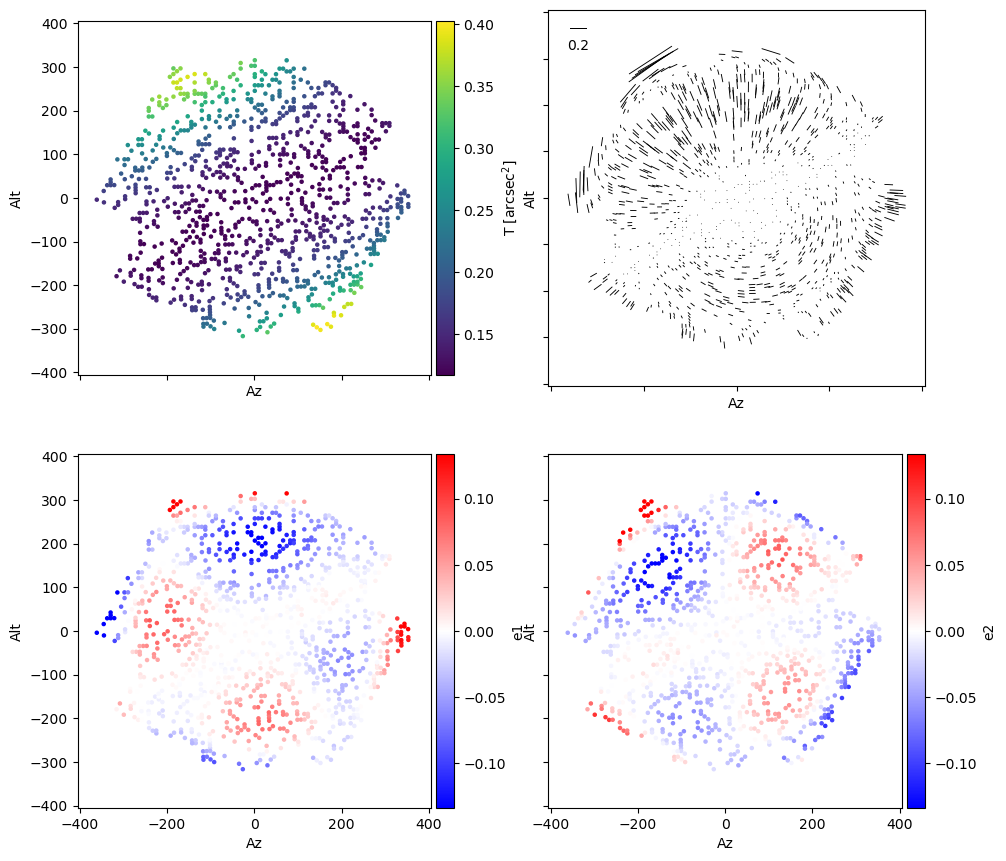

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeAzElPlot(fig, axes, table, camera)
plt.show()

In [21]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeFocalPlanePlot(fig, axes, table, camera)
# plt.show()

In [22]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
# makeEquatorialPlot(fig, axes, table, camera)
# plt.show()

# Convert mm to field angle and write output file

In [23]:
from ellipticity_util import addFieldCoords_to_Table, makeOCSPlot, read_batoid_table, addOpticalCoords_to_Table
import numpy as np

In [24]:
table = addOpticalCoords_to_Table( table )

In [25]:
table = addFieldCoords_to_Table( table, camera )

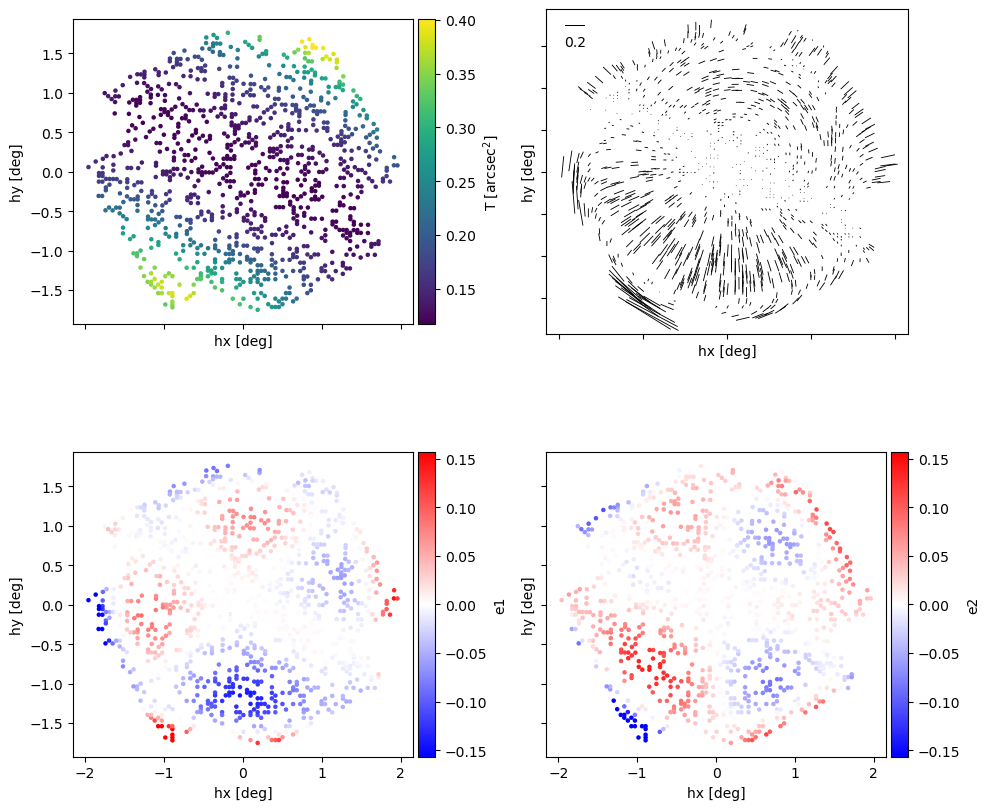

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True)
makeOCSPlot(fig, axes, table, camera)
plt.show()

In [33]:
from astropy.io import ascii

In [34]:
outname = folder + 'rzs/ellip_maps/imsim_seq%.8d.csv'%seqnum
outname = folder + 'imsim_seq%.8d.csv'%seqnum
# outname = '/home/r/rzanmar/coords_seq%.8d.csv'%seqnum

In [35]:
outname

'/sdf/data/rubin/shared/image_quality/imsim/imsim_seq00000182.csv'

In [36]:
ascii.write(table[ 'oc_field_x','oc_field_y','oc_Ixx','oc_Iyy','oc_Ixy', ],outname, format='csv', fast_writer=False, overwrite=True)

In [45]:
table.meta['ocRot']

array([[ 0.50193363, -0.86490614],
       [-0.86490614, -0.50193363]])

# verify mm to field [deg] conversion

In [37]:
hx, hy = table['x'] * 0.2 / 36, table['y'] * 0.2 / 36      # 0.2 arcsec / pix * pix / 10um -> 0.2/36 deg/mm

In [38]:
hx_rot, hy_rot = table['oc_x'] * 0.2 / 36, table['oc_y'] * 0.2 / 36

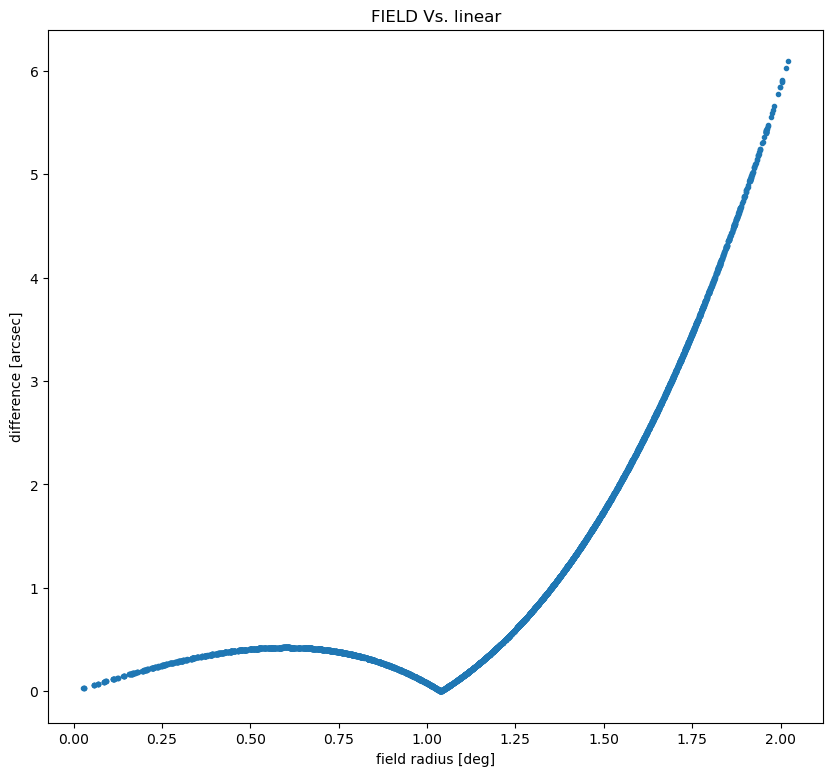

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 9), sharex=True, sharey=True)
plt.plot( np.sqrt( table['oc_field_x']**2+table['oc_field_y']**2), np.sqrt( (table['oc_field_x'] - hx_rot)**2 + (table['oc_field_y'] - hy_rot)**2)*3600, '.' )
axes.set_xlabel('field radius [deg]')
axes.set_ylabel('difference [arcsec]')
axes.set_title('FIELD Vs. linear')
plt.show()

In [40]:
table.meta['aaRot']

array([[ 0.50193363, -0.86490614],
       [ 0.86490614,  0.50193363]])

In [41]:
table.meta['ocRot']

array([[ 0.50193363, -0.86490614],
       [-0.86490614, -0.50193363]])